# New York City Taxi Trip Duration

Share code and data to improve ride time predictions

---

## Contents

- 원데이터 EDA
- 독립변수 수정 / 추가
- 레버리지, 이상치
- 스케일링
- 다중공선성


---

## 0. Setting 

사용한 패키지 - 문수님꺼 import로 가져오는데 일부가 import 안되는 경우가 있어서 일단 이렇게 로드했습니다. 나중에 수정

In [1]:
# Taxi package
import pandas as pd
import numpy as np
import scipy as sp

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import sklearn as sk

import datetime as dt
from patsy import dmatrix

import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes(palette="muted")

def get_features(data, start_num=0, end_num=None, scale=False):
    """
    from data, choose the columns to use OLS
    (default is all columns)
    """
    features = list(data.columns)[start_num:end_num]
    feature_n = len(features)

    if scale:
        features = list(map(lambda x: "scale({})".format(x), features))
        features = " + ".join(features)

    else:
        features = " + ".join(features)

    return feature_n, features

def erase_outlier_np(result, data, total_feature, category=False, dropped=False):
    """
    get the fitted model result, then erase outliers in data,
    by Fox' Outlier Recommendation.
    print the number of erased outlier
    return arranged data, dropped data(when True)
    """

    influence = result.get_influence()

    if category:
        fox_cr = 4 / (len(data) - total_feature)
    else:
        fox_cr = 4 / (len(data) - total_feature - 1)

    cooks_d2, pvals = influence.cooks_distance
    idx = np.where(cooks_d2 > fox_cr)[0]

    dropped_data = data.iloc[idx]
    data = data.drop(data.index[idx])
    data.reset_index(drop=True, inplace=True)

    if dropped:

        return data, dropped_data

    return data

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    All args must be of equal length.
    """

    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c

    return km

/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# encoding data package
'''
need to install holidays
pip install holidays
https://github.com/dr-prodigy/python-holidays
'''

import numpy as np
import pandas as pd
import datetime as dt
import holidays

from taxi_pakage import haversine_np

datezero = dt.datetime(2016, 1, 1, 0, 0, 1) # 기준

def strptime(x):
    return dt.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
def date_to_zero(x):
    return int((x-datezero).days)
def time_to_zero(x):
    return int((x-datezero).seconds)
def week_num(x):
    return int(x.weekday()) + 1 # erase 0

us_holidays = holidays.US(state='NY', years=2016)

def holiday(x):
    if x in us_holidays:
        return 2
    else:
        x = x.weekday()
    if x > 4:
        return 1
    else:
        return 1

def holiday_Fri(x): #with Friday
    if x in us_holidays:
        return 2
    else:
        x = x.weekday()
    if x > 3:
        return 1
    else:
        return 1

추가해야 할 함수

In [3]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
from patsy import dmatrix
from statsmodels.stats.outliers_influence import variance_inflation_factor

---

## 1. 원데이터 EDA

- 종합 EDA
- 개별 EDA

### 1) 종합 EDA

In [4]:
# data set
taxi = pd.read_csv('train.csv')
taxi.tail()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.98,40.75,-73.99,40.74,N,778
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.00,40.75,-73.97,40.80,N,655
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.96,40.77,-74.00,40.71,N,764
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.98,40.75,-73.97,40.76,N,373
1458643,id1209952,1,2016-04-05 14:44:25,2016-04-05 14:47:43,1,-73.98,40.78,-73.97,40.79,N,198


In [5]:
# 데이터 크기
taxi.shape # 1,458,644개 데이터, 11개의 컬럼으로 구성

(1458644, 11)

In [6]:
# 데이터에 대한 정보 (컬럼 개수, null값 여부, 데이터 유형)
taxi.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


- object : id, pickup_datetime, dropoff_datetime, store_and_fwd_flag
- int : vendor_id, passenger_count, trip_duration
- float : pickup_logitude, pickup_latitude, dropoff_logitude, dropoff_latitude

In [7]:
# Descriptive statistics
taxi.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00
mean,1.53,1.66,-73.97,40.75,-73.97,40.75,959.49
std,0.50,1.31,0.07,0.03,0.07,0.04,5237.43
min,1.00,0.00,-121.93,34.36,-121.93,32.18,1.00
25%,1.00,1.00,-73.99,40.74,-73.99,40.74,397.00
50%,2.00,1.00,-73.98,40.75,-73.98,40.75,662.00
75%,2.00,2.00,-73.97,40.77,-73.96,40.77,1075.00
max,2.00,9.00,-61.34,51.88,-61.34,43.92,3526282.00


### 2) 개별 변수 EDA

#### (1) vendor_id

In [8]:
# table
vendor = pd.DataFrame(taxi, columns=['vendor_id'])
vendor = taxi.groupby(['vendor_id']).size().reset_index(name='Counts')
vendor

,vendor_id,Counts
0,1,678342
1,2,780302


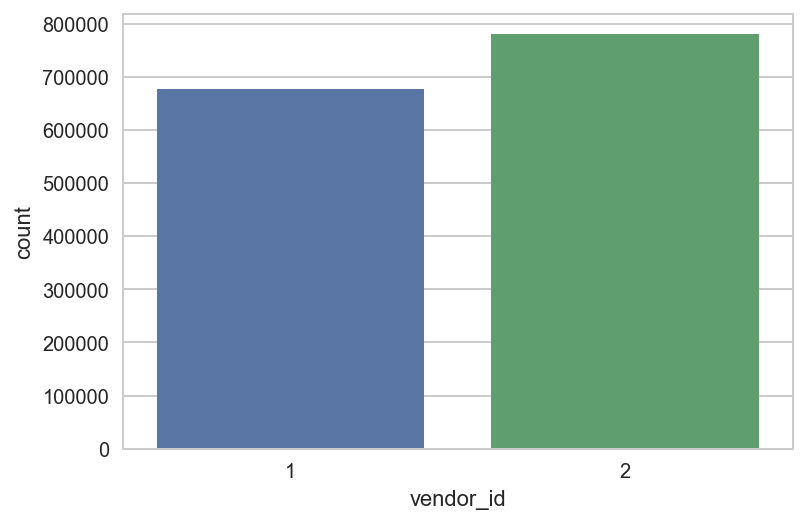

In [9]:
# countplot
sns.countplot(x = 'vendor_id', data = taxi)
plt.show()

#### (2) passenger_count

In [10]:
# table
passenger = pd.DataFrame(taxi, columns=['passenger_count'])
passenger = taxi.groupby(['passenger_count']).size().reset_index(name='Counts')
passenger

,passenger_count,Counts
0,0,60
1,1,1033540
2,2,210318
3,3,59896
4,4,28404
5,5,78088
6,6,48333
7,7,3
8,8,1
9,9,1


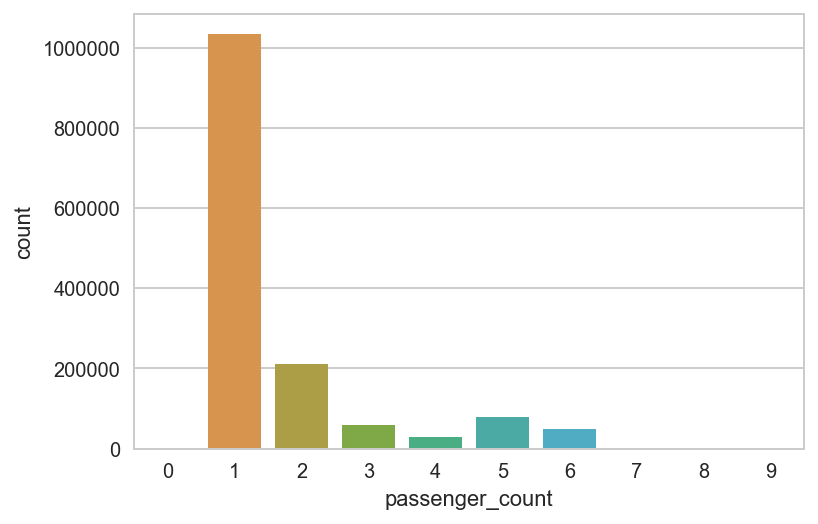

In [11]:
# countplot
sns.countplot(x = 'passenger_count', data = taxi)
plt.show()

#### (3) pickup_longitude

In [13]:
# descriptive statistics
taxi['pickup_longitude'].describe()

count   1458644.00
mean        -73.97
std           0.07
min        -121.93
25%         -73.99
50%         -73.98
75%         -73.97
max         -61.34
Name: pickup_longitude, dtype: float64

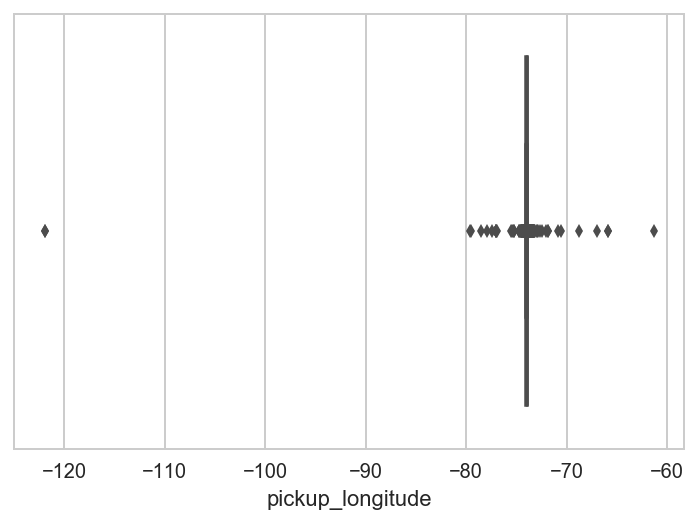

In [14]:
# boxplot
sns.boxplot(x = 'pickup_longitude', data = taxi)
plt.show()

#### (4) pickup_longitude

In [15]:
# descriptive statistics
taxi['pickup_longitude'].describe()

count   1458644.00
mean        -73.97
std           0.07
min        -121.93
25%         -73.99
50%         -73.98
75%         -73.97
max         -61.34
Name: pickup_longitude, dtype: float64

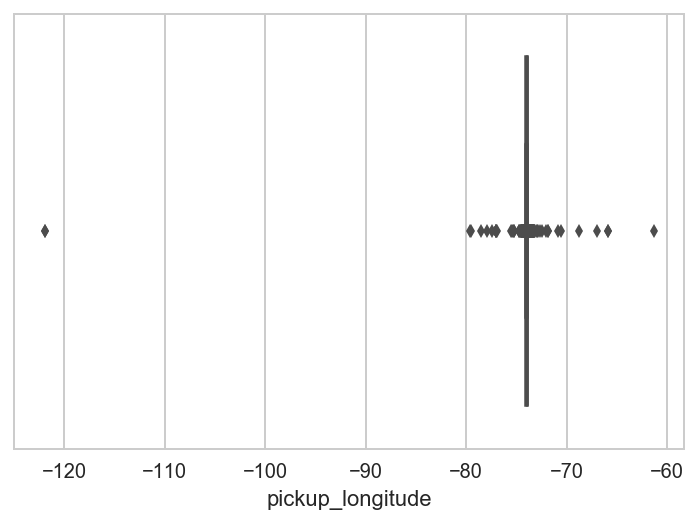

In [16]:
# boxplot
sns.boxplot(x = 'pickup_longitude', data = taxi)
plt.show()

#### (5) dropoff_latitude

In [17]:
# descriptive statistics
taxi['dropoff_latitude'].describe()

count   1458644.00
mean         40.75
std           0.04
min          32.18
25%          40.74
50%          40.75
75%          40.77
max          43.92
Name: dropoff_latitude, dtype: float64

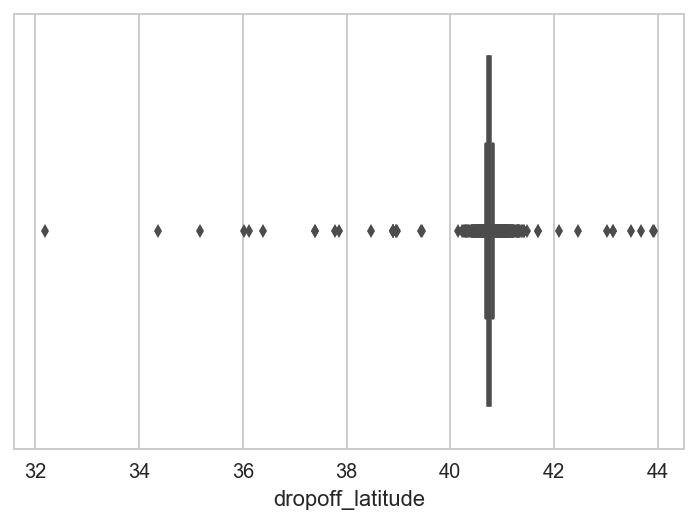

In [18]:
# boxplot
sns.boxplot(x = 'dropoff_latitude', data = taxi)
plt.show()

#### (6) dropoff_latitude

In [19]:
# descriptive statistics
taxi['dropoff_latitude'].describe()

count   1458644.00
mean         40.75
std           0.04
min          32.18
25%          40.74
50%          40.75
75%          40.77
max          43.92
Name: dropoff_latitude, dtype: float64

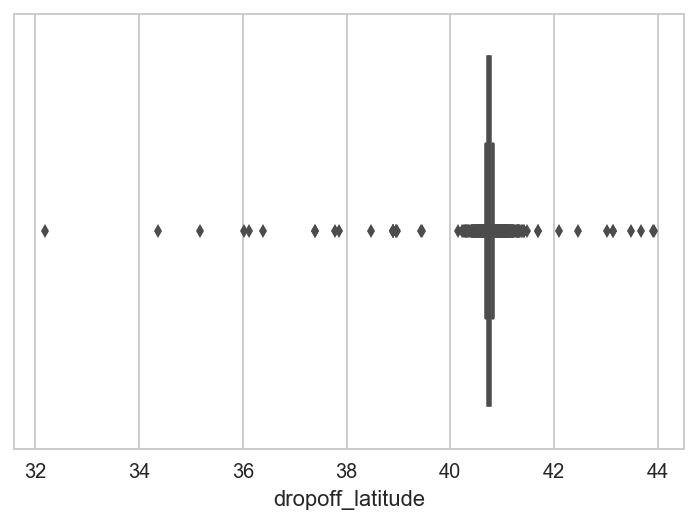

In [20]:
# boxplot
sns.boxplot(x = 'dropoff_latitude', data = taxi)
plt.show()

#### (7) sotre_and_fwd_flag

In [21]:
# table
store = pd.DataFrame(taxi, columns=['store_and_fwd_flag'])
store = taxi.groupby(['store_and_fwd_flag']).size().reset_index(name='Counts')
store

,store_and_fwd_flag,Counts
0,N,1450599
1,Y,8045


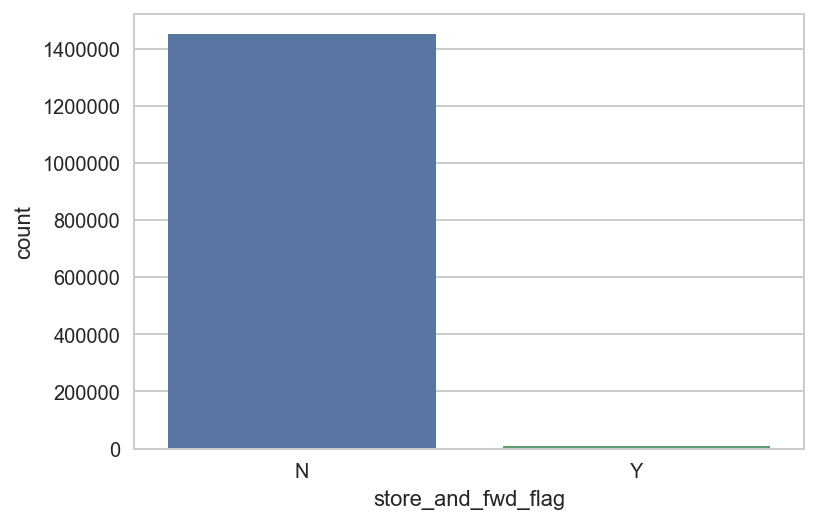

In [22]:
# countplot
sns.countplot(x = 'store_and_fwd_flag', data = taxi)
plt.show()

#### (8) trip_duration

In [23]:
# descriptive statistics
taxi["trip_duration"].describe()

count   1458644.00
mean        959.49
std        5237.43
min           1.00
25%         397.00
50%         662.00
75%        1075.00
max     3526282.00
Name: trip_duration, dtype: float64

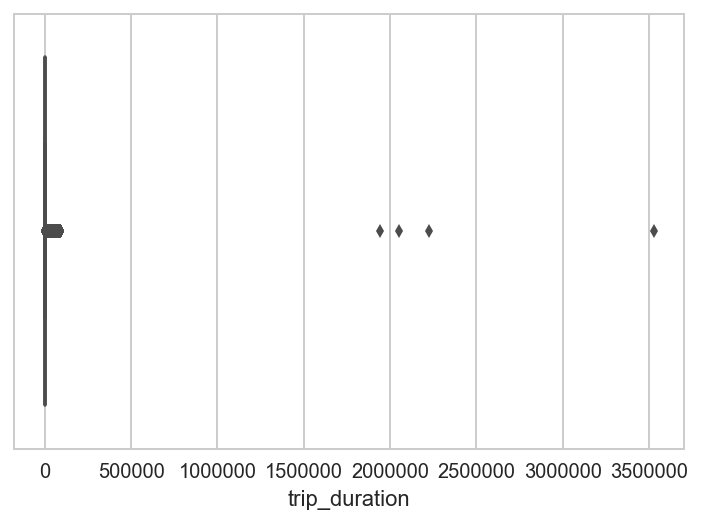

In [24]:
# boxplot
sns.boxplot(x = 'trip_duration', data = taxi)
plt.show()

---

## 2. 독립변수 수정 / 추가

#### 1) id

In [25]:
# id값을 숫자화
taxi['id'] = taxi['id'].apply(lambda x: x[2:])

#### 2) dist

In [26]:
# 좌표를 이용해 거리 생성
taxi['dist'] = haversine_np(taxi['pickup_longitude'], taxi['pickup_latitude'], taxi['dropoff_longitude'], taxi['dropoff_latitude'])

#### 3) store_and_fwd_flag

In [27]:
# N,Y 문자로 된 데이터를 0, 1 숫자로 변경
taxi['store_and_fwd_flag'] = taxi['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)

#### 4) date 관련 변수 생성

In [28]:
# 기존의 변수 재정의
taxi['pickup_datetime'] = taxi['pickup_datetime'].apply(strptime)
taxi['dropoff_datetime'] = taxi['dropoff_datetime'].apply(strptime)
taxi['pick_date'] = taxi['pickup_datetime'].apply(date_to_zero)
taxi['pick_time'] = taxi['pickup_datetime'].apply(time_to_zero)
taxi['drop_time'] = taxi['dropoff_datetime'].apply(time_to_zero)

# 새로운 변수 생성
taxi['holiday'] = taxi['pickup_datetime'].apply(holiday)
taxi['holiday_Fri'] = taxi['pickup_datetime'].apply(holiday_Fri)
taxi['weekday'] = taxi['pickup_datetime'].apply(week_num)

#### 5) 최종 데이터

In [29]:
# 종속변수를 제일 끝 column으로 보냄
temp = taxi['trip_duration'] 
taxi = taxi.drop(['pickup_datetime','dropoff_datetime','trip_duration'], axis=1)
taxi['trip_duration'] = temp
taxi.to_csv('edited_taxi.csv', index = False)

---

## 3. 레버리지, 이상치

### 1) 원데이터 분석

#### (1) Setting

In [39]:
# 최종 데이터 로드
taxi = pd.read_csv('edited_taxi.csv')
feature_n, features = get_features(taxi)

In [40]:
# data_transformed
test = dmatrix('{}'.format(features), taxi, return_type = 'dataframe' )
test.tail()

,Intercept,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,dist,pick_date,pick_time,drop_time,holiday,holiday_Fri,weekday,trip_duration
1458639,1.00,2376096.00,2.00,4.00,-73.98,40.75,-73.99,40.74,0.00,1.22,98.00,48663.00,49441.00,1.00,1.00,5.00,778.00
1458640,1.00,1049543.00,1.00,1.00,-74.00,40.75,-73.97,40.80,0.00,6.05,9.00,27314.00,27969.00,1.00,1.00,7.00,655.00
1458641,1.00,2304944.00,2.00,1.00,-73.96,40.77,-74.00,40.71,0.00,7.82,112.00,25060.00,25824.00,1.00,1.00,5.00,764.00
1458642,1.00,2714485.00,1.00,1.00,-73.98,40.75,-73.97,40.76,0.00,1.09,4.00,57385.00,57758.00,1.00,1.00,2.00,373.00
1458643,1.00,1209952.00,1.00,1.00,-73.98,40.78,-73.97,40.79,0.00,1.13,95.00,53064.00,53262.00,1.00,1.00,2.00,198.00


In [41]:
# 독립변수 X 생성
feature_n, features = get_features(test, 1, -1)
feature_n, features

(15,
 'id + vendor_id + passenger_count + pickup_longitude + pickup_latitude + dropoff_longitude + dropoff_latitude + store_and_fwd_flag + dist + pick_date + pick_time + drop_time + holiday + holiday_Fri + weekday')

#### (2) 전체 데이터 분석

- Modeling

In [42]:
model =  sm.OLS.from_formula("trip_duration ~ {}".format(features), data=test)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          trip_duration   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1015.
Date:                Fri, 09 Mar 2018   Prob (F-statistic):               0.00
Time:                        18:02:50   Log-Likelihood:            -1.4554e+07
No. Observations:             1458644   AIC:                         2.911e+07
Df Residuals:                 1458629   BIC:                         2.911e+07
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           1.023e+05   8493.067     12.046      0.000    8.57e+04    1.19e+05
id                 -8.155e-06   3.74e-06     -2.182      0.029   -1.55e-05    -8.3e-07
vendor_id            199.8535      9.062     22.055      0.000     182.093     217.614
passenger_count        8.0735      3.430      2.354      0.019       1.351      14.796
pickup_longitude     -25.9003    101.892     -0.254      0.799    -225.605     173.804
pickup_latitude    -1369.3814    154.253     -8.877      0.000   -1671.712   -1067.051
dropoff_longitude    316.4521    100.094      3.162      0.002     120.271     512.634
dropoff_latitude    -606.9214    139.448     -4.352      0.000    -880.235    -333.608
store_and_fwd_flag    49.0105     58.482      0.838      0.402     -65.613     163.634
dist                 112.0741      1.076    104.183      0.000     109.966     114.182
pick_date              0.4856      0.085      5.743      0.000       0.320       0.651
pick_time             -0.0046      0.001     -8.958      0.000      -0.006      -0.004
drop_time              0.0061      0.001     11.963      0.000       0.005       0.007
holiday              -53.9221     14.060     -3.835      0.000     -81.479     -26.365
holiday_Fri          -53.9221     14.060     -3.835      0.000     -81.479     -26.365
weekday               -3.7525      2.233     -1.681      0.093      -8.129       0.624
================================================================================
Omnibus:                  8314604.750   Durbin-Watson:                     2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   2324412381812002.000
Skew:                         347.728   Prob(JB):                           0.00
Kurtosis:                  195565.153   Cond. No.                       3.32e+21
================================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.05e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

R-squared도 너무 낮고 cond.No.가 너무 크다 $\rightarrow$ 안좋은 데이터

- ANOVA Table

In [43]:
# 전체 독립변수에 대한 ANOVA Table 작성
sm.stats.anova_lm(result, typ=2)

,sum_sq,df,F,PR(>F)
id,129342424.19,1.00,4.76,0.03
vendor_id,13214098861.25,1.00,486.42,0.00
passenger_count,150521008.92,1.00,5.54,0.02
pickup_longitude,1755338.81,1.00,0.06,0.80
pickup_latitude,2140971588.95,1.00,78.81,0.00
dropoff_longitude,271535779.79,1.00,10.00,0.00
dropoff_latitude,514598699.26,1.00,18.94,0.00
store_and_fwd_flag,19079196.05,1.00,0.70,0.40
dist,294867860652.91,1.00,10854.19,0.00
pick_date,895852130.87,1.00,32.98,0.00


#### (3) 카테고리 값 분석

In [44]:
model_c =  sm.OLS.from_formula("trip_duration ~ C(vendor_id) +C(passenger_count) + C(holiday) + C(holiday_Fri) + C(weekday) + 0", data=test)
result_c = model_c.fit()
result_c.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          trip_duration   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     40.82
Date:                Fri, 09 Mar 2018   Prob (F-statistic):          2.50e-144
Time:                        18:05:48   Log-Likelihood:            -1.4561e+07
No. Observations:             1458644   AIC:                         2.912e+07
Df Residuals:                 1458625   BIC:                         2.912e+07
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
C(vendor_id)[1.0]          1581.7045    676.098      2.339      0.019     256.576    2906.833
C(vendor_id)[2.0]          1788.5451    676.100      2.645      0.008     463.413    3113.677
C(passenger_count)[T.1.0]  -799.3133    676.006     -1.182      0.237   -2124.263     525.636
C(passenger_count)[T.2.0]  -740.6616    676.082     -1.096      0.273   -2065.760     584.437
C(passenger_count)[T.3.0]  -728.4958    676.325     -1.077      0.281   -2054.070     597.078
C(passenger_count)[T.4.0]  -694.5209    676.699     -1.026      0.305   -2020.828     631.786
C(passenger_count)[T.5.0]  -768.0375    676.262     -1.136      0.256   -2093.488     557.413
C(passenger_count)[T.6.0]  -777.3415    676.422     -1.149      0.250   -2103.106     548.423
C(passenger_count)[T.7.0] -1802.8545   3097.753     -0.582      0.561   -7874.344    4268.635
C(passenger_count)[T.8.0] -1679.8229   5279.748     -0.318      0.750    -1.2e+04    8668.301
C(passenger_count)[T.9.0] -1317.1267   5279.612     -0.249      0.803   -1.17e+04    9030.732
C(holiday)[T.2.0]         -1.934e+11   2.52e+13     -0.008      0.994   -4.95e+13    4.91e+13
C(holiday_Fri)[T.2.0]      1.934e+11   2.52e+13      0.008      0.994   -4.91e+13    4.95e+13
C(weekday)[T.2.0]            75.5326     17.061      4.427      0.000      42.094     108.971
C(weekday)[T.3.0]            68.2510     16.921      4.034      0.000      35.087     101.415
C(weekday)[T.4.0]            99.1807     16.771      5.914      0.000      66.310     132.051
C(weekday)[T.5.0]            88.5842     16.430      5.392      0.000      56.382     120.786
C(weekday)[T.6.0]            36.5045     16.742      2.180      0.029       3.691      69.319
C(weekday)[T.7.0]           -10.1248     17.217     -0.588      0.556     -43.869      23.620
================================================================================
Omnibus:                  8287328.916   Durbin-Watson:                     2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   2248819699421057.250
Skew:                         343.445   Prob(JB):                           0.00
Kurtosis:                  192358.902   Cond. No.                       9.14e+12
================================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.16e-20. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [45]:
sm.stats.anova_lm(result_c, typ=2)

,sum_sq,df,F,PR(>F)
C(vendor_id),14313904604.95,2.00,261.04,0.00
C(passenger_count),1092152255.15,9.00,4.43,0.00
C(holiday),1618.17,1.00,0.00,0.99
C(holiday_Fri),1618.17,1.00,0.00,0.99
C(weekday),2257066116.10,6.00,13.72,0.00
Residual,39991438529055.36,1458625.00,nan,nan


#### (4) 잔차 정규성

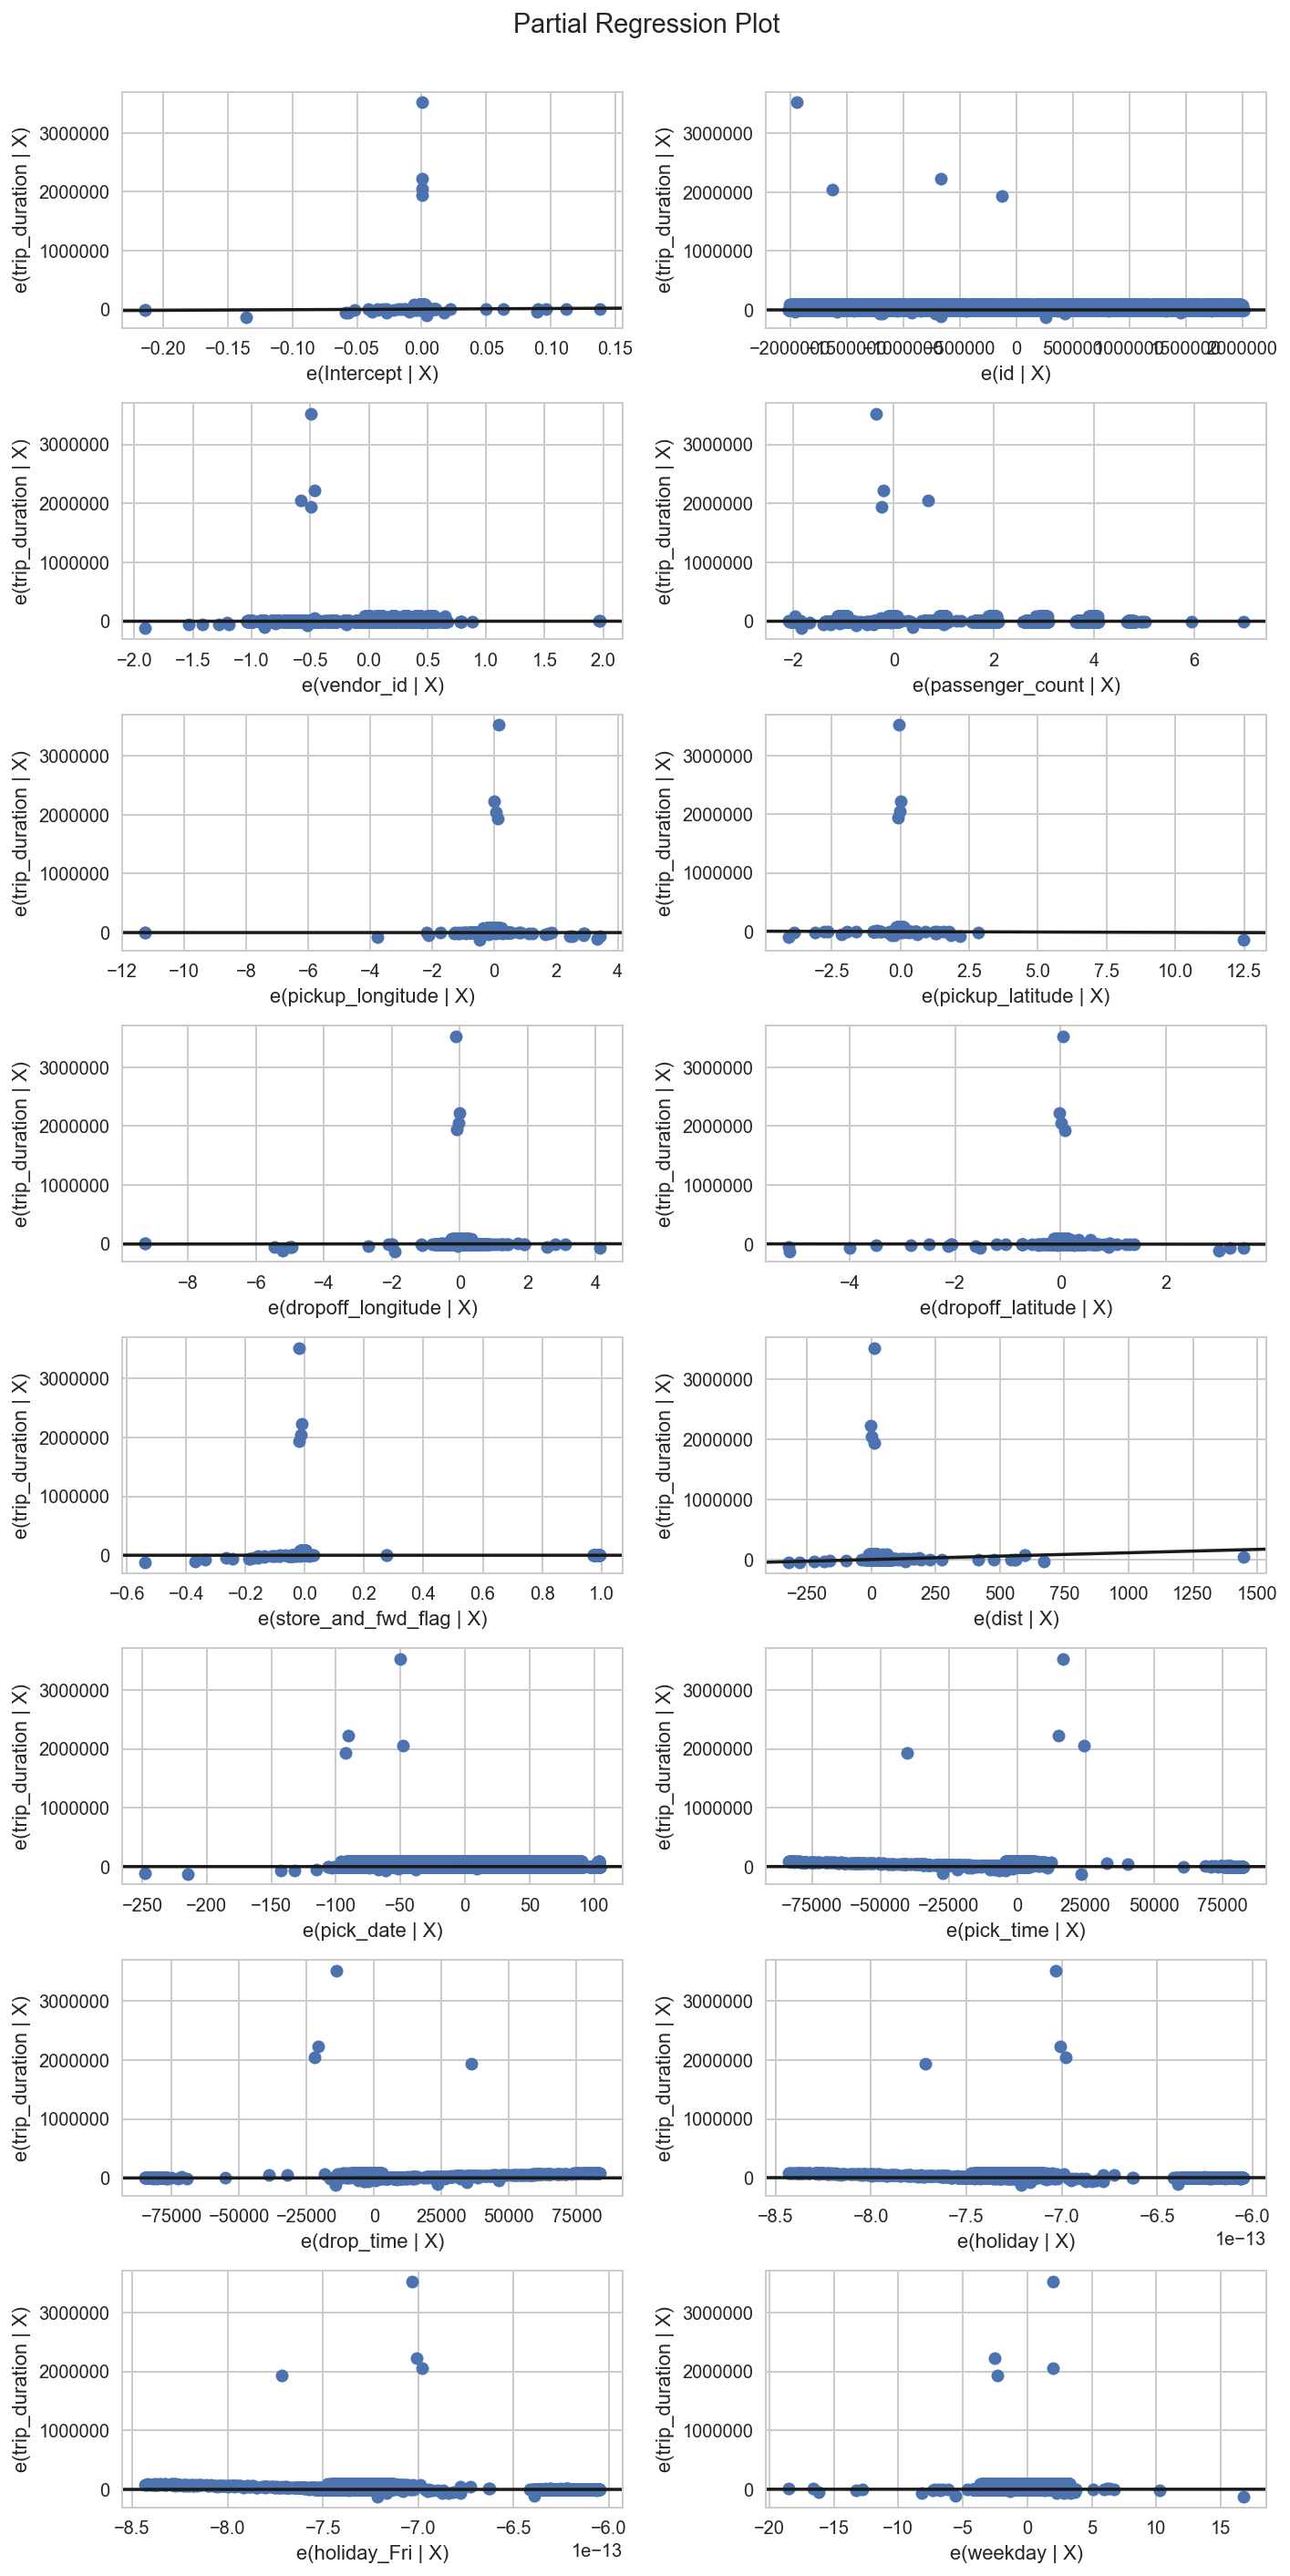

In [156]:
fig = plt.figure(figsize=(10,20))
sm.graphics.plot_partregress_grid(result, fig=fig)
plt.show()

### 2) Cook's Distance를 통한 아웃라이어 제거

In [47]:
# use outlier function
outlier, Dropped = erase_outlier_np(result, test, feature_n, dropped=True)
len(outlier), len(Dropped)

(1456336, 2308)

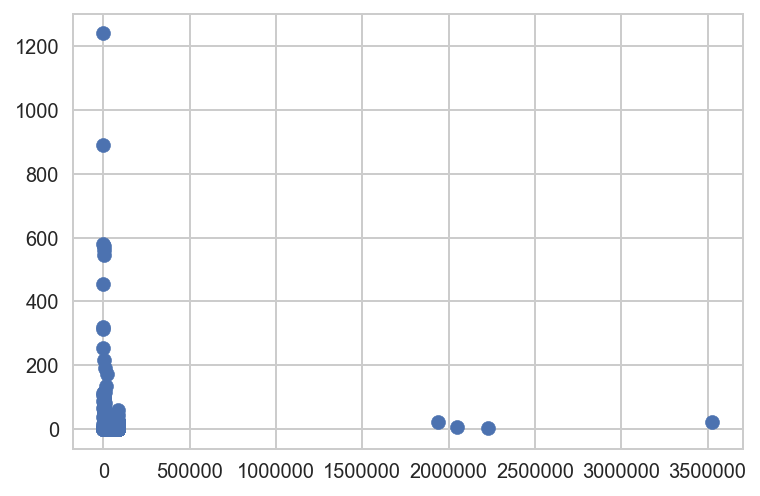

In [50]:
# outlier 제거 확인 (trip_duration, dist)
plt.scatter(Dropped['trip_duration'], Dropped['dist'])

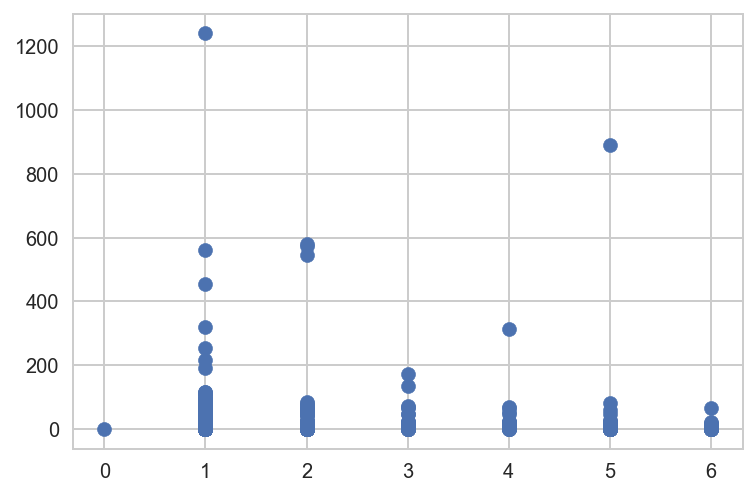

In [68]:
# outlier 제거 확인 (trip_duration, dist)
plt.scatter(Dropped['passenger_count'], Dropped['dist'])

### 3) 결과 확인

In [51]:
model =  sm.OLS.from_formula("trip_duration ~ {}".format(features), data=outlier)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          trip_duration   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                 1.609e+05
Date:                Fri, 09 Mar 2018   Prob (F-statistic):               0.00
Time:                        18:07:39   Log-Likelihood:            -1.0834e+07
No. Observations:             1456336   AIC:                         2.167e+07
Df Residuals:                 1456321   BIC:                         2.167e+07
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -9.815e+04   1292.624    -75.928      0.000   -1.01e+05   -9.56e+04
id                  6.091e-07   2.95e-07      2.062      0.039    3.01e-08    1.19e-06
vendor_id              0.8220      0.716      1.147      0.251      -0.582       2.226
passenger_count        3.4676      0.271     12.784      0.000       2.936       3.999
pickup_longitude    -556.0068     10.498    -52.963      0.000    -576.583    -535.431
pickup_latitude     1016.8754     14.104     72.097      0.000     989.231    1044.519
dropoff_longitude   -933.8218     10.461    -89.265      0.000    -954.325    -913.318
dropoff_latitude   -1302.7571     11.935   -109.154      0.000   -1326.149   -1279.365
store_and_fwd_flag    34.6800      4.628      7.493      0.000      25.609      43.751
dist                 135.7033      0.112   1216.538      0.000     135.485     135.922
pick_date              0.5479      0.007     81.958      0.000       0.535       0.561
pick_time             -0.0016    4.1e-05    -38.534      0.000      -0.002      -0.001
drop_time              0.0029   4.05e-05     70.544      0.000       0.003       0.003
holiday              -52.5037      1.111    -47.240      0.000     -54.682     -50.325
holiday_Fri          -52.5037      1.111    -47.240      0.000     -54.682     -50.325
weekday              -13.4475      0.177    -76.152      0.000     -13.794     -13.101
==============================================================================
Omnibus:                   785183.786   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         21739060.516
Skew:                           2.060   Prob(JB):                         0.00
Kurtosis:                      21.474   Cond. No.                     5.27e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.8e-23. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

결정계수는 높였지만 Cond.No.는 아직도 큰 상태

### 4) 변수제거

#### (1) 변수 제거

In [52]:
test = outlier.drop(["id", "store_and_fwd_flag", "holiday_Fri"], axis = 1)

In [53]:
feature_n, features = get_features(test, 1, -1)
feature_n, features

(12,
 'vendor_id + passenger_count + pickup_longitude + pickup_latitude + dropoff_longitude + dropoff_latitude + dist + pick_date + pick_time + drop_time + holiday + weekday')

In [54]:
test.tail()

,Intercept,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,dist,pick_date,pick_time,drop_time,holiday,weekday,trip_duration
1456331,1.00,2.00,4.00,-73.98,40.75,-73.99,40.74,1.22,98.00,48663.00,49441.00,1.00,5.00,778.00
1456332,1.00,1.00,1.00,-74.00,40.75,-73.97,40.80,6.05,9.00,27314.00,27969.00,1.00,7.00,655.00
1456333,1.00,2.00,1.00,-73.96,40.77,-74.00,40.71,7.82,112.00,25060.00,25824.00,1.00,5.00,764.00
1456334,1.00,1.00,1.00,-73.98,40.75,-73.97,40.76,1.09,4.00,57385.00,57758.00,1.00,2.00,373.00
1456335,1.00,1.00,1.00,-73.98,40.78,-73.97,40.79,1.13,95.00,53064.00,53262.00,1.00,2.00,198.00


In [55]:
model =  sm.OLS.from_formula("trip_duration ~ {}".format(features), data=test)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          trip_duration   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                 1.877e+05
Date:                Fri, 09 Mar 2018   Prob (F-statistic):               0.00
Time:                        18:08:00   Log-Likelihood:            -1.0834e+07
No. Observations:             1456336   AIC:                         2.167e+07
Df Residuals:                 1456323   BIC:                         2.167e+07
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -9.804e+04   1292.580    -75.852      0.000   -1.01e+05   -9.55e+04
vendor_id             0.4093      0.714      0.573      0.567      -0.991       1.809
passenger_count       3.4706      0.271     12.794      0.000       2.939       4.002
pickup_longitude   -555.4365     10.498    -52.909      0.000    -576.012    -534.861
pickup_latitude    1017.0712     14.105     72.109      0.000     989.427    1044.716
dropoff_longitude  -933.3510     10.461    -89.220      0.000    -953.855    -912.847
dropoff_latitude  -1303.5085     11.935   -109.218      0.000   -1326.900   -1280.117
dist                135.7174      0.112   1216.816      0.000     135.499     135.936
pick_date             0.5479      0.007     81.955      0.000       0.535       0.561
pick_time            -0.0016    4.1e-05    -38.542      0.000      -0.002      -0.001
drop_time             0.0029   4.05e-05     70.563      0.000       0.003       0.003
holiday            -104.9994      2.223    -47.235      0.000    -109.356    -100.643
weekday             -13.4525      0.177    -76.179      0.000     -13.799     -13.106
==============================================================================
Omnibus:                   785142.326   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         21734243.707
Skew:                           2.059   Prob(JB):                         0.00
Kurtosis:                      21.472   Cond. No.                     2.98e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.98e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

변수 제거를 통해 Cond.No를 줄임

(2) 잔차 정규성

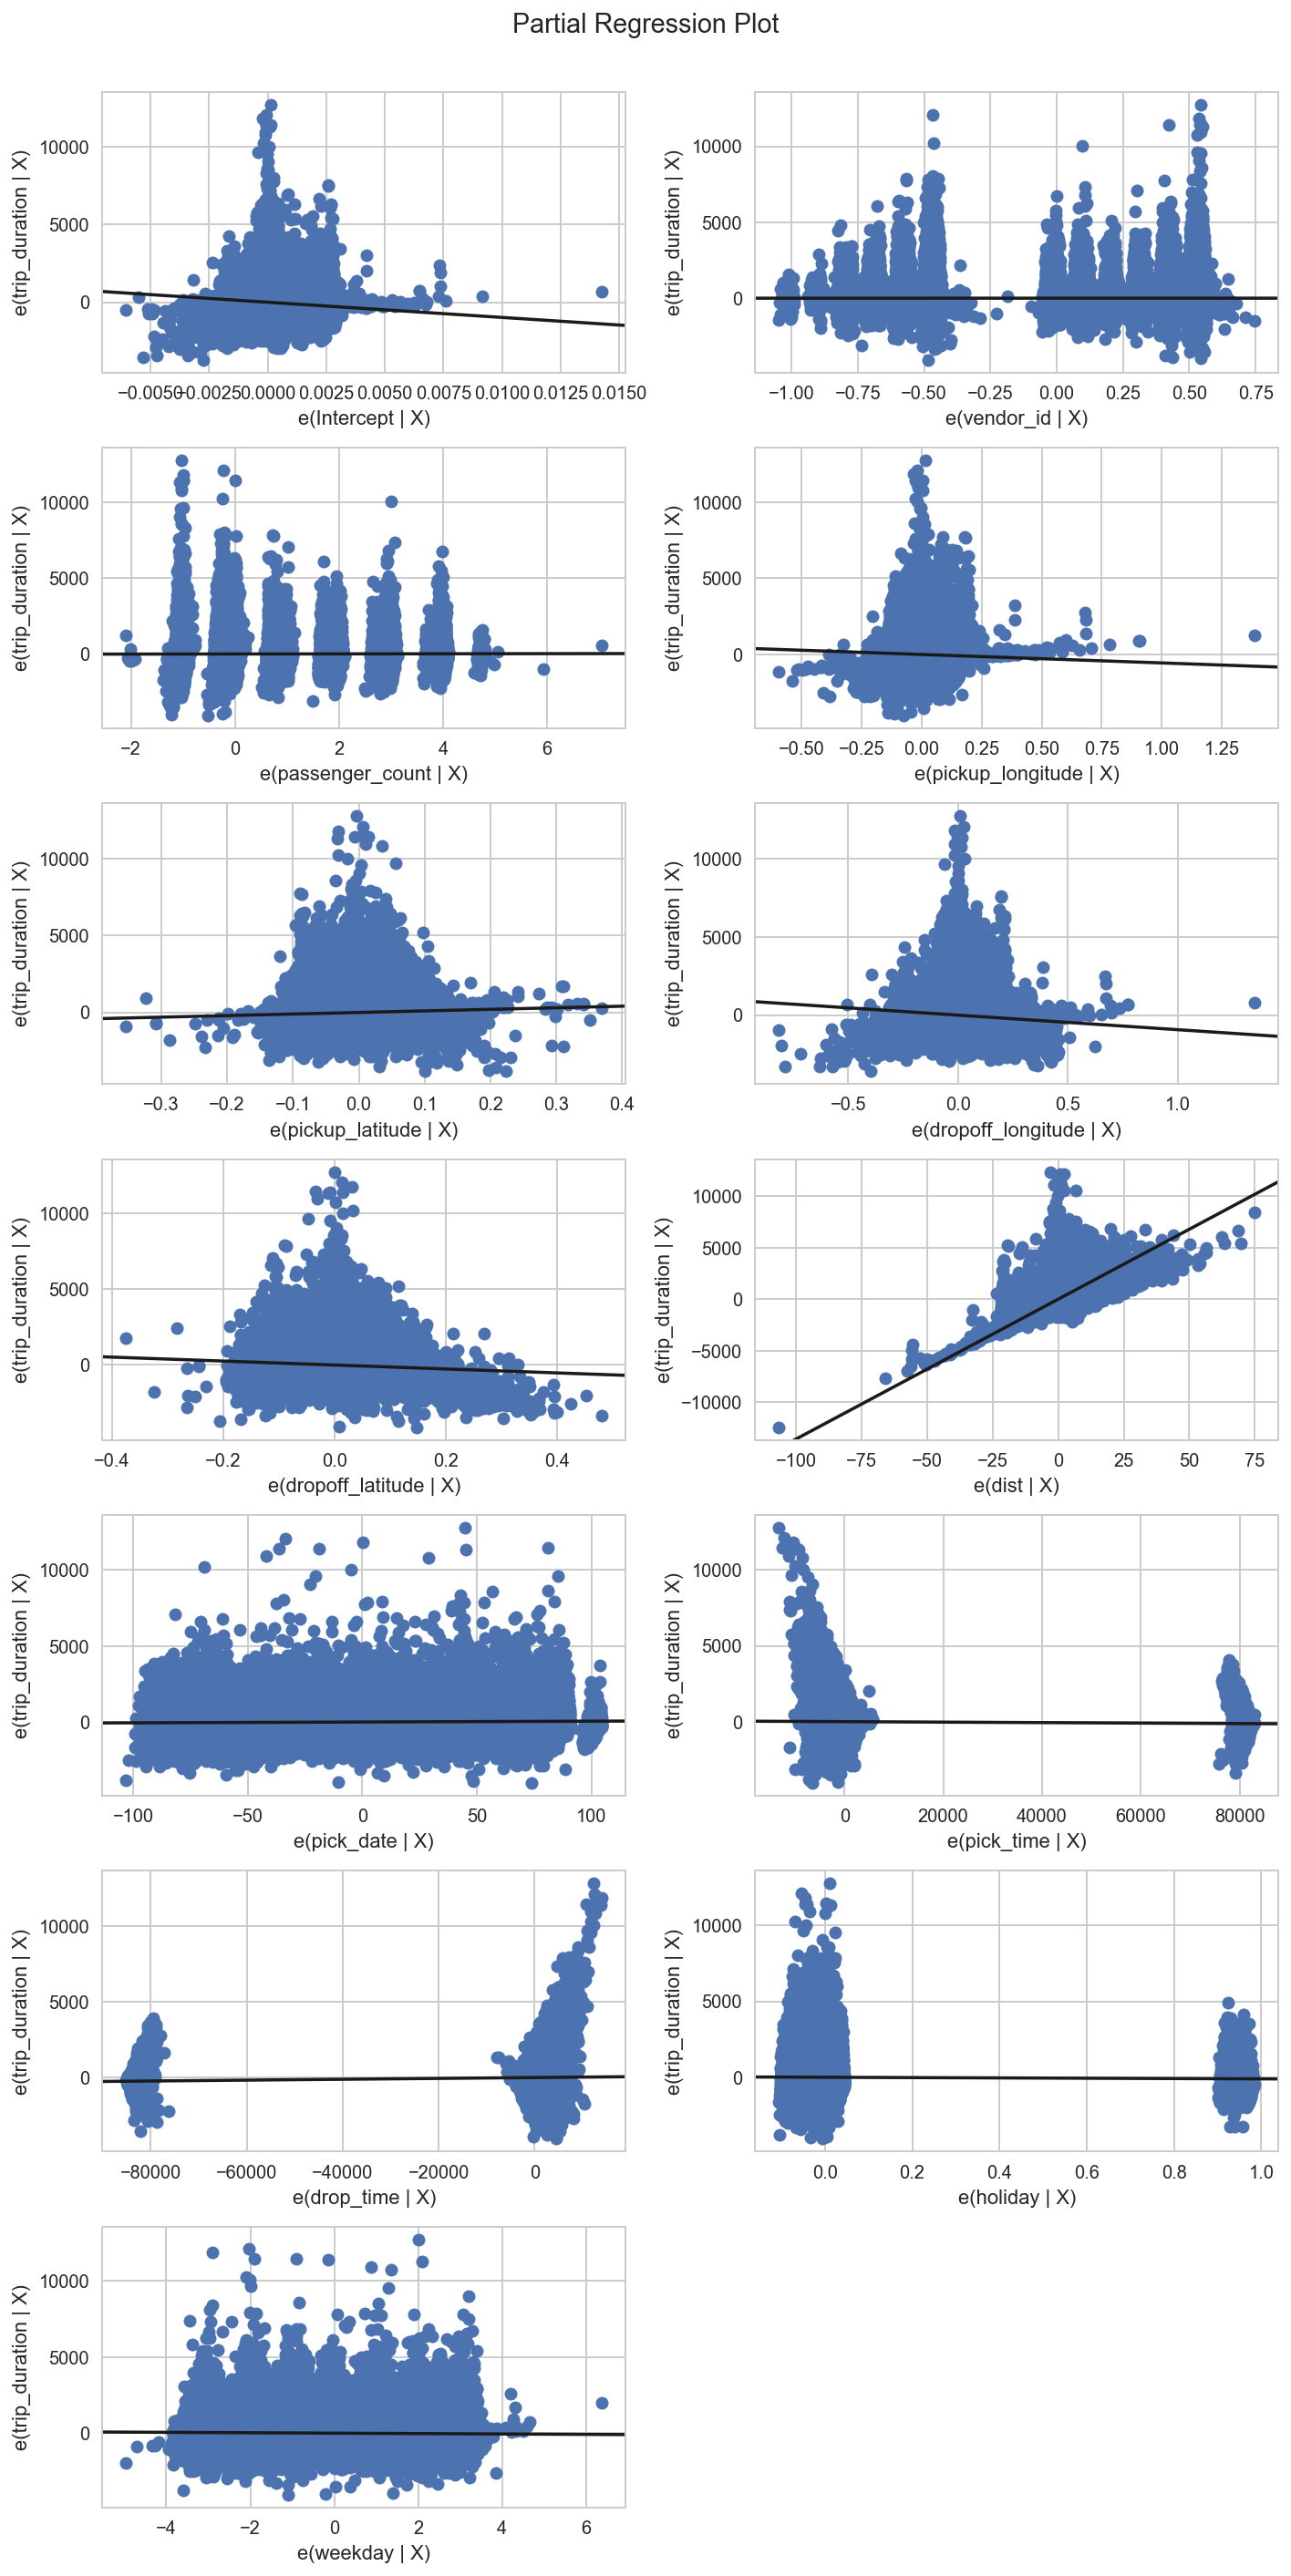

In [116]:
fig = plt.figure(figsize=(10,20))
sm.graphics.plot_partregress_grid(result, fig=fig)
plt.show()

---

## 4. 스케일링

In [56]:
test.tail()

,Intercept,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,dist,pick_date,pick_time,drop_time,holiday,weekday,trip_duration
1456331,1.00,2.00,4.00,-73.98,40.75,-73.99,40.74,1.22,98.00,48663.00,49441.00,1.00,5.00,778.00
1456332,1.00,1.00,1.00,-74.00,40.75,-73.97,40.80,6.05,9.00,27314.00,27969.00,1.00,7.00,655.00
1456333,1.00,2.00,1.00,-73.96,40.77,-74.00,40.71,7.82,112.00,25060.00,25824.00,1.00,5.00,764.00
1456334,1.00,1.00,1.00,-73.98,40.75,-73.97,40.76,1.09,4.00,57385.00,57758.00,1.00,2.00,373.00
1456335,1.00,1.00,1.00,-73.98,40.78,-73.97,40.79,1.13,95.00,53064.00,53262.00,1.00,2.00,198.00


In [57]:
# feature 개수 재정의
feature_n, features = get_features(test, 2, -3, scale=True)
feature_n, features

(9,
 'scale(passenger_count) + scale(pickup_longitude) + scale(pickup_latitude) + scale(dropoff_longitude) + scale(dropoff_latitude) + scale(dist) + scale(pick_date) + scale(pick_time) + scale(drop_time)')

In [58]:
# dmatrix 재정의
test = dmatrix("trip_duration + vendor_id +weekday + holiday + {}".format(features), test, return_type ="dataframe")

In [59]:
test = test.rename(index=str, 
            columns={'scale(passenger_count)':'passenger_count', 
                         'scale(pickup_longitude)':'pickup_longitude',
                         'scale(pickup_latitude)':'pickup_latitude', 
                         'scale(dropoff_longitude)':'dropoff_longitude',
                         'scale(dropoff_latitude)':'dropoff_latitude', 
                         'scale(dist)':'dist',
                         'scale(pick_date)' : 'pick_date',
                         'scale(pick_time)'  : 'pick_time', 
                         'scale(drop_time)' : 'drop_time',})

In [60]:
# 카테고리 값을 분리
feature_n, features = get_features(test, 5, scale=False)
feature_n, features

(9,
 'passenger_count + pickup_longitude + pickup_latitude + dropoff_longitude + dropoff_latitude + dist + pick_date + pick_time + drop_time')

In [61]:
model =  sm.OLS.from_formula("trip_duration ~ C(vendor_id) +C(weekday) + C(holiday) + {} ".format(features), data=test)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          trip_duration   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                 1.359e+05
Date:                Fri, 09 Mar 2018   Prob (F-statistic):               0.00
Time:                        18:12:56   Log-Likelihood:            -1.0823e+07
No. Observations:             1456336   AIC:                         2.165e+07
Df Residuals:                 1456318   BIC:                         2.165e+07
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             802.2051      1.047    766.023      0.000     800.153     804.258
C(vendor_id)[T.2.0]     0.3416      0.709      0.482      0.630      -1.048       1.731
C(weekday)[T.2.0]      62.0896      1.333     46.596      0.000      59.478      64.701
C(weekday)[T.3.0]      86.7069      1.322     65.608      0.000      84.117      89.297
C(weekday)[T.4.0]      93.8344      1.310     71.630      0.000      91.267      96.402
C(weekday)[T.5.0]      78.3847      1.284     61.043      0.000      75.868      80.901
C(weekday)[T.6.0]      -9.5334      1.310     -7.276      0.000     -12.101      -6.965
C(weekday)[T.7.0]     -71.7665      1.349    -53.198      0.000     -74.411     -69.122
C(holiday)[T.2.0]     -86.4922      2.273    -38.059      0.000     -90.946     -82.038
passenger_count         5.1551      0.354     14.576      0.000       4.462       5.848
pickup_longitude      -21.0358      0.401    -52.507      0.000     -21.821     -20.251
pickup_latitude        27.8441      0.395     70.561      0.000      27.071      28.618
dropoff_longitude     -33.8357      0.375    -90.197      0.000     -34.571     -33.100
dropoff_latitude      -42.1007      0.383   -109.832      0.000     -42.852     -41.349
dist                  531.9345      0.433   1227.599      0.000     531.085     532.784
pick_date              28.5215      0.342     83.357      0.000      27.851      29.192
pick_time             -40.0398      0.938    -42.685      0.000     -41.878     -38.201
drop_time              67.7404      0.938     72.194      0.000      65.901      69.579
==============================================================================
Omnibus:                   785471.274   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         22566007.441
Skew:                           2.049   Prob(JB):                         0.00
Kurtosis:                      21.844   Cond. No.                         11.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

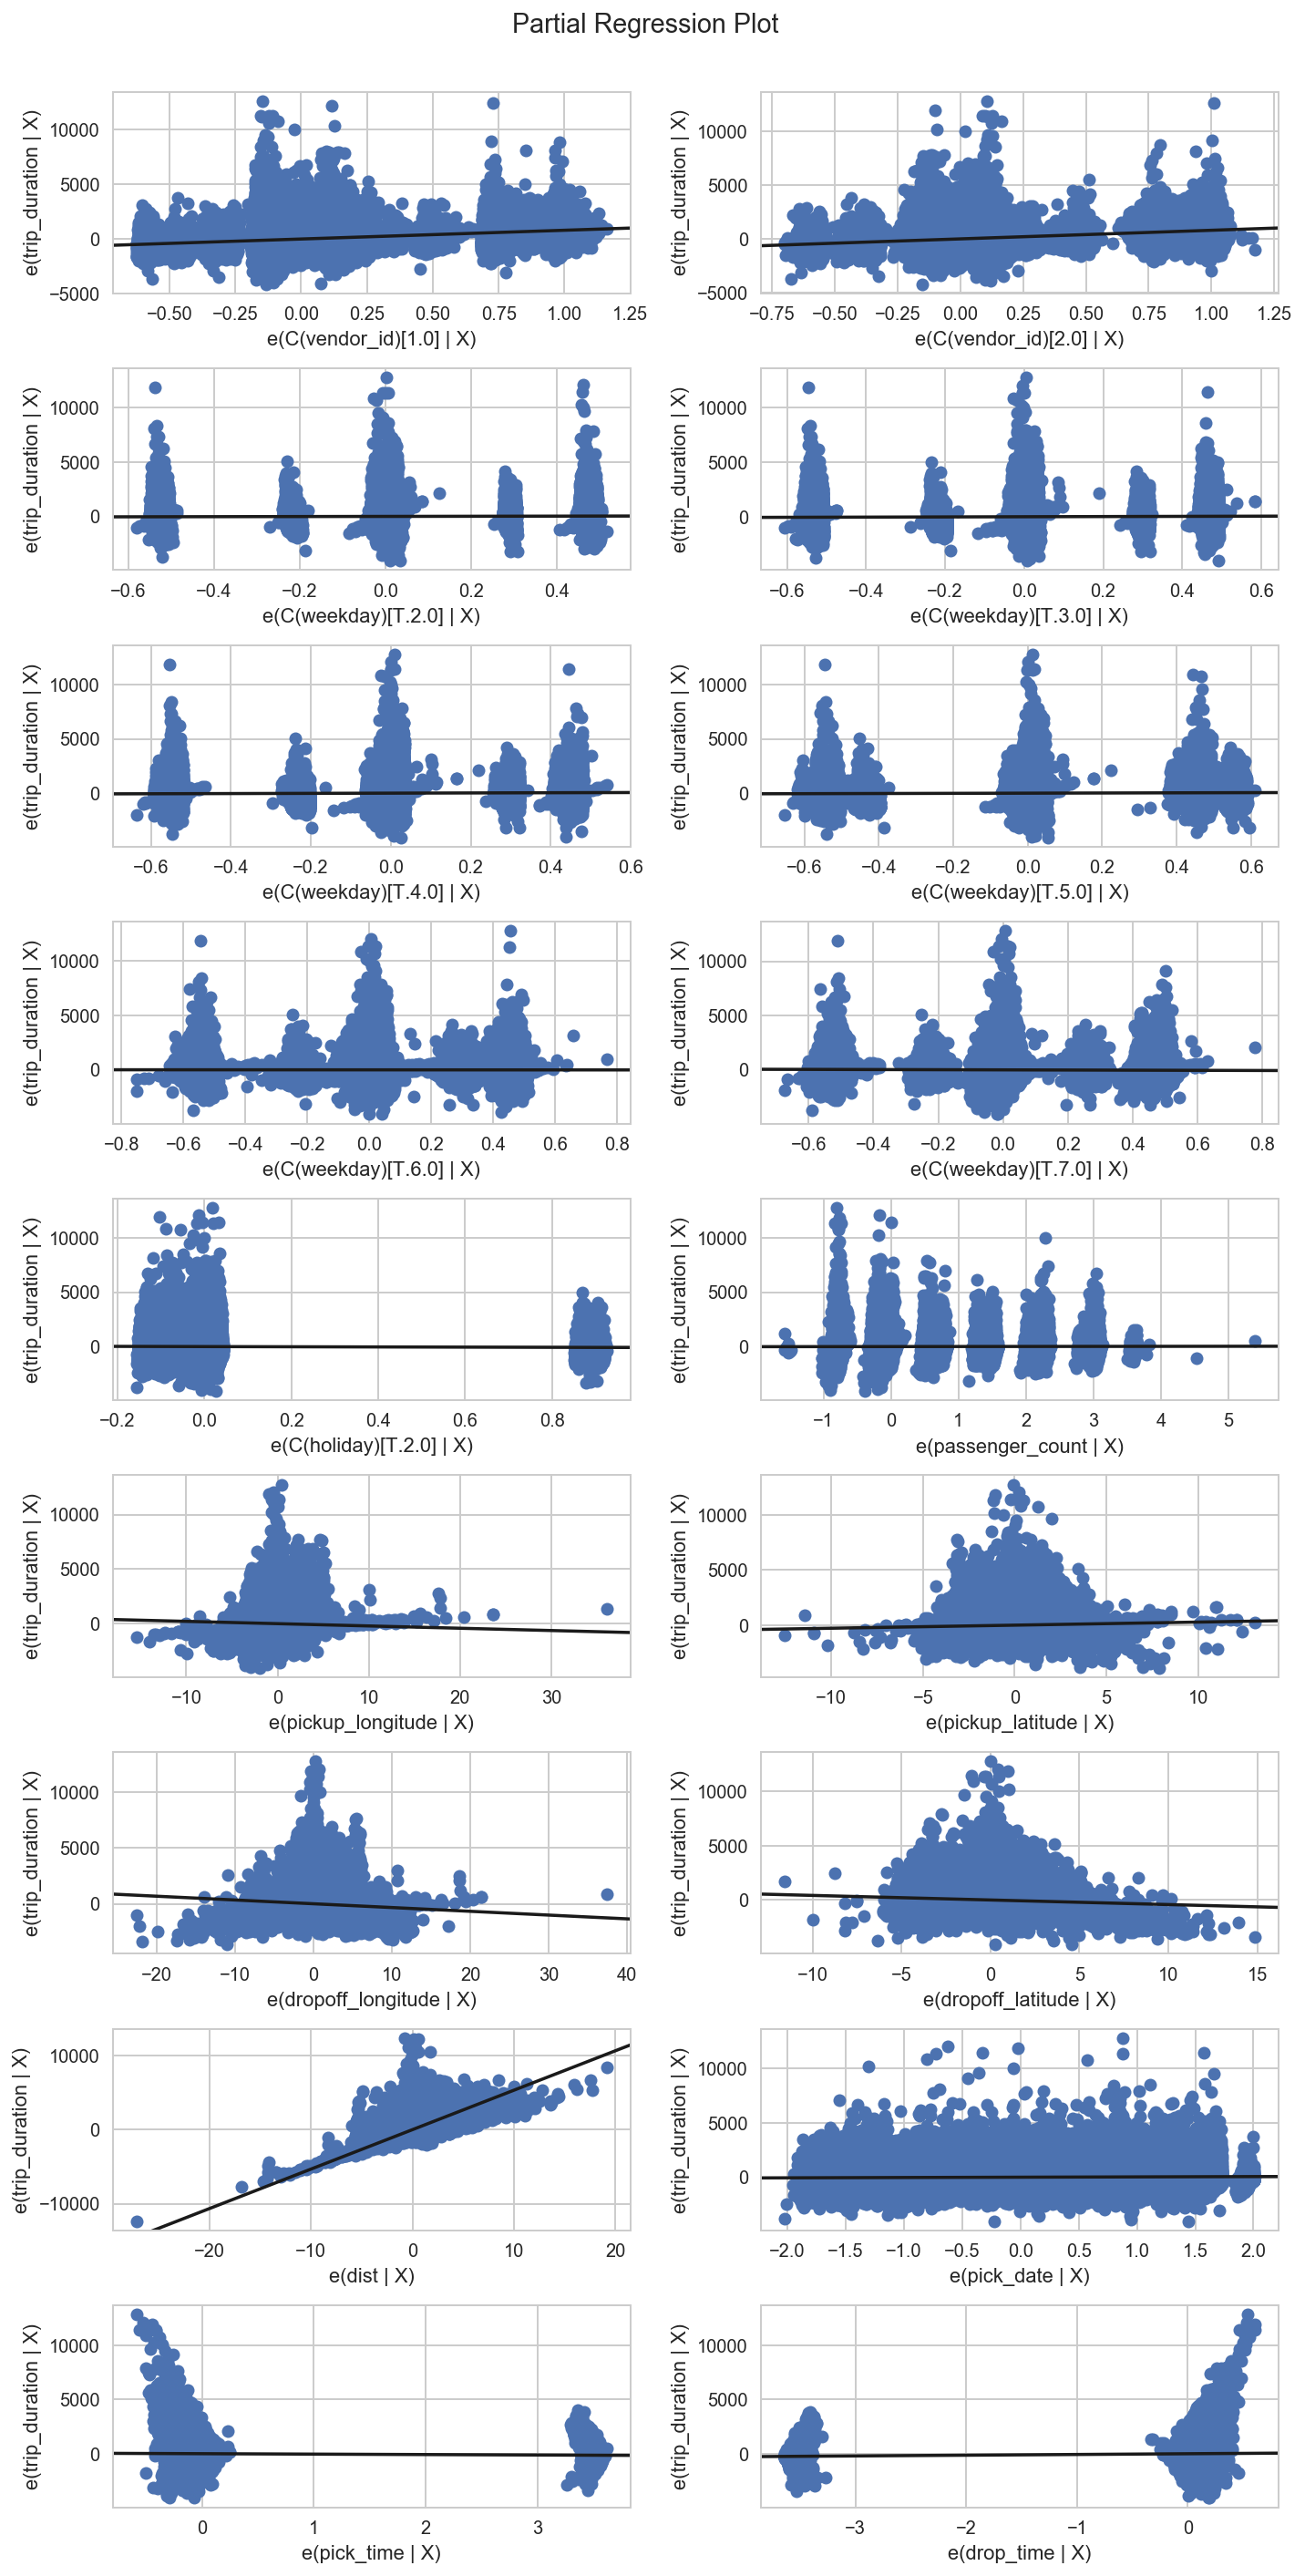

In [125]:
fig = plt.figure(figsize=(10,20))
sm.graphics.plot_partregress_grid(result, fig=fig)
plt.show()

---

## 5. 다중공선성

### 1) 상관 분석

In [62]:
test_cor = test.drop(["Intercept","trip_duration"], axis = 1)

In [63]:
test_cor.corr()

,vendor_id,weekday,holiday,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,dist,pick_date,pick_time,drop_time
vendor_id,1.00,0.00,0.00,0.29,0.02,0.00,0.00,0.00,0.01,-0.01,0.01,0.01
weekday,0.00,1.00,-0.10,0.03,-0.03,-0.03,-0.00,-0.02,0.01,-0.01,-0.08,-0.09
holiday,0.00,-0.10,1.00,0.00,0.01,-0.00,0.00,-0.00,0.01,-0.14,-0.01,-0.01
passenger_count,0.29,0.03,0.00,1.00,0.00,-0.01,-0.00,-0.00,0.01,-0.00,0.01,0.01
pickup_longitude,0.02,-0.03,0.01,0.00,1.00,-0.14,0.29,0.04,0.51,0.01,0.02,0.02
pickup_latitude,0.00,-0.03,-0.00,-0.01,-0.14,1.00,0.05,0.43,-0.31,-0.00,0.01,0.02
dropoff_longitude,0.00,-0.00,0.00,-0.00,0.29,0.05,1.00,0.13,0.36,0.01,-0.04,-0.04
dropoff_latitude,0.00,-0.02,-0.00,-0.00,0.04,0.43,0.13,1.00,-0.16,-0.00,0.02,0.02
dist,0.01,0.01,0.01,0.01,0.51,-0.31,0.36,-0.16,1.00,0.02,-0.02,-0.02
pick_date,-0.01,-0.01,-0.14,-0.00,0.01,-0.00,0.01,-0.00,0.02,1.00,-0.00,-0.00


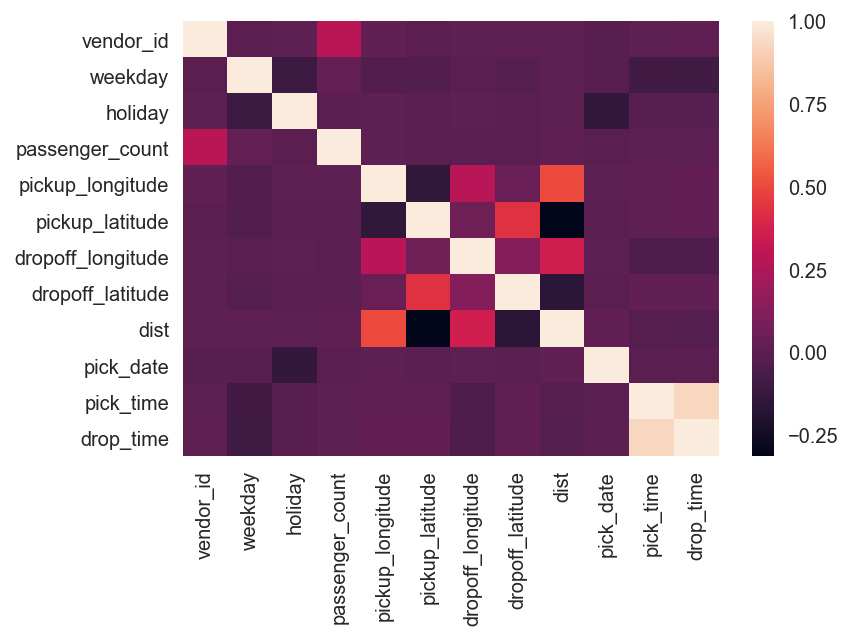

In [64]:
sns.heatmap(test_cor.corr())
plt.show()

### 2) VIF (Variance Inflation Factor)

In [65]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(test_cor.values, i) for i in range(test_cor.shape[1])]
vif["features"] = test_cor.columns
vif

,VIF Factor,features
0,9.55,vendor_id
1,4.73,weekday
2,11.34,holiday
3,1.07,passenger_count
4,1.40,pickup_longitude
5,1.36,pickup_latitude
6,1.23,dropoff_longitude
7,1.28,dropoff_latitude
8,1.64,dist
9,1.00,pick_date


VIF값이 10이상인 holiday를 제거함

In [70]:
test = test_cor.drop(["holiday"], axis = 1)

ValueError: labels ['holiday'] not contained in axis

In [71]:
model =  sm.OLS.from_formula("trip_duration ~ C(vendor_id) +C(weekday) + C(holiday) + {} ".format(features), data=test)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          trip_duration   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                 1.359e+05
Date:                Fri, 09 Mar 2018   Prob (F-statistic):               0.00
Time:                        18:18:52   Log-Likelihood:            -1.0823e+07
No. Observations:             1456336   AIC:                         2.165e+07
Df Residuals:                 1456318   BIC:                         2.165e+07
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             802.2051      1.047    766.023      0.000     800.153     804.258
C(vendor_id)[T.2.0]     0.3416      0.709      0.482      0.630      -1.048       1.731
C(weekday)[T.2.0]      62.0896      1.333     46.596      0.000      59.478      64.701
C(weekday)[T.3.0]      86.7069      1.322     65.608      0.000      84.117      89.297
C(weekday)[T.4.0]      93.8344      1.310     71.630      0.000      91.267      96.402
C(weekday)[T.5.0]      78.3847      1.284     61.043      0.000      75.868      80.901
C(weekday)[T.6.0]      -9.5334      1.310     -7.276      0.000     -12.101      -6.965
C(weekday)[T.7.0]     -71.7665      1.349    -53.198      0.000     -74.411     -69.122
C(holiday)[T.2.0]     -86.4922      2.273    -38.059      0.000     -90.946     -82.038
passenger_count         5.1551      0.354     14.576      0.000       4.462       5.848
pickup_longitude      -21.0358      0.401    -52.507      0.000     -21.821     -20.251
pickup_latitude        27.8441      0.395     70.561      0.000      27.071      28.618
dropoff_longitude     -33.8357      0.375    -90.197      0.000     -34.571     -33.100
dropoff_latitude      -42.1007      0.383   -109.832      0.000     -42.852     -41.349
dist                  531.9345      0.433   1227.599      0.000     531.085     532.784
pick_date              28.5215      0.342     83.357      0.000      27.851      29.192
pick_time             -40.0398      0.938    -42.685      0.000     -41.878     -38.201
drop_time              67.7404      0.938     72.194      0.000      65.901      69.579
==============================================================================
Omnibus:                   785471.274   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         22566007.441
Skew:                           2.049   Prob(JB):                         0.00
Kurtosis:                      21.844   Cond. No.                         11.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

제거해도 크게 상관 없다는 것을 알 수 있음

## 오버피팅

### 1) Overfitting (과최적화)

- 오버피팅을 확인해야 하는 이유는 가지고 있는 데이터의 예측률은 높아질 수 있지만 다른 외부에서 가져온 데이터를 입력하면 출력값이 부정확할 가능성이 높기 때문 (가지고 있는 데이터만 최적화된 식을 뽑아내기 때문)

### 2) Cross validation (교차 검증)
- 오버피팅을 확인하는 방법 (트레이닝/테스트 데이터 셋트를 여러개 생성 - 이들가지고 테스트 하고 각 트레이닝 데이터의 평균성능, 성능 분산, 테스트 데이터의 평균성능, 성능 분산을 구하고 각각을 비교해본다)

- from sklearn.model_selection import train_test_split X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

- test_size 를 33%로 하겠다 (train data는 67%)

#### k-fold

### 3) Regularized (정규화)

오버피팅을 확인했을 때 이를 어떻게 해결할 것인가에 대한 문제, 차수를 제거해 식을 간단히 해야 하는데 어떤걸 빼야하는가?

## 토요일 수업하면서 해야 할 것들 정리
다항회귀 적용해보기 (x를 가지고 이것저것 만져보자 (제곱, 세제곱, 로그 등등)

우리가 지금까지 한게 오버피팅을 한것인지 확인해 볼 필요가 있음